In [6]:
!pip install category_encoders
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline
sns.set(color_codes=True)
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
import scipy.stats as stats

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/Sleep_Data_Sampled.csv')

 Data Understanding and Observation

Checking Data shape
Get summary statistics (count, mean, std, min, max, percentiles) for all numerical columns.


In [9]:
print("Dataset Shape:", df.shape)

print("\nSummary Statistics:\n", df.describe())
print("\nInfor", df.info())

Dataset Shape: (15000, 13)

Summary Statistics:
           Person ID           Age  Sleep Duration  Quality of Sleep  \
count  15000.000000  15000.000000    15000.000000      15000.000000   
mean    7500.500000     44.130667        6.997327          7.131267   
std     4330.271354      6.840091        0.615187          1.053111   
min        1.000000     27.000000        5.800000          4.000000   
25%     3750.750000     40.000000        6.500000          6.000000   
50%     7500.500000     44.000000        7.000000          7.000000   
75%    11250.250000     48.000000        7.450000          8.000000   
max    15000.000000     59.000000        8.500000          9.000000   

       Physical Activity Level  Stress Level    Heart Rate   Daily Steps  
count             15000.000000  15000.000000  15000.000000  15000.000000  
mean                 59.925000      5.654800     70.857533   6795.080000  
std                  16.814374      1.393568      3.614836   1329.706484  
min        

1. Find Missing Values


In [10]:
missing_summary = df.isnull().sum()
print("Missing Values per Column:\n", missing_summary)

Missing Values per Column:
 Person ID                  0
Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64


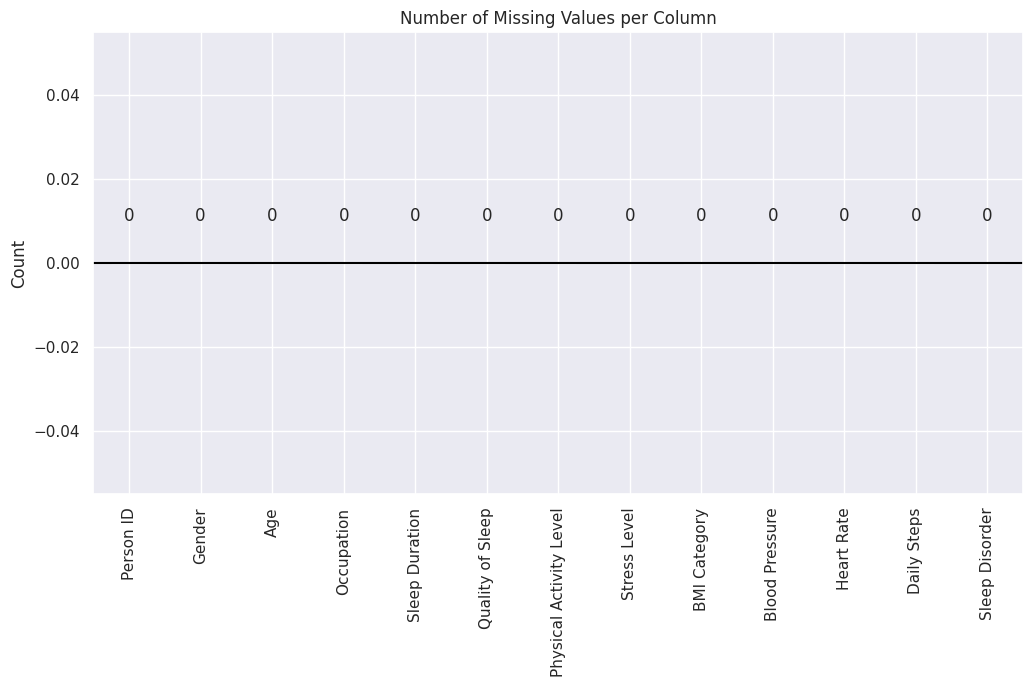

In [11]:
# Another effective visualization: a bar plot of the null counts
null_counts = df.isnull().sum()
plt.figure(figsize=(12, 6))
null_plot = null_counts.plot(kind='bar')
plt.title("Number of Missing Values per Column")
plt.ylabel("Count")
plt.axhline(y=0, color='black', linestyle='-') # This line will be at zero
# Annotate the bars with the value (which is 0)
for i, v in enumerate(null_counts):
    null_plot.text(i, v + 0.01, str(v), ha='center')
plt.show()

Created a heatmap and a bar plot. The heatmap is a uniform color, with no light-colored bars, confirming no missing data. Similarly, the bar plot shows all counts at zero for every column. This proves that the step of imputation or deletion for missing values was not necessary for our dataset.

1.1 Find Duplicates

In [12]:
full_duplicates = df.duplicated().sum()
print("Number of Full-Row Duplicates:", full_duplicates)
df = df.drop_duplicates()

Number of Full-Row Duplicates: 0


In [13]:
if 'Person ID' in df.columns:
    key_duplicates = df.duplicated(subset=['Person ID']).sum()
    print("Number of Key-Based Duplicates (on Person ID):", key_duplicates)
    df = df.drop_duplicates(subset=['Person ID'], keep='first')

print("\nDataset Shape After Removing Duplicates:", df.shape)

Number of Key-Based Duplicates (on Person ID): 0

Dataset Shape After Removing Duplicates: (15000, 13)


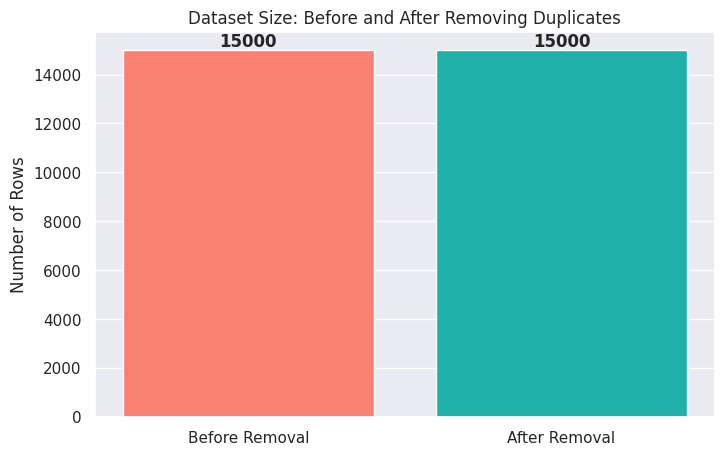

In [14]:
import matplotlib.pyplot as plt

# Data for the plot: BEFORE and AFTER
status = ['Before Removal', 'After Removal']
rows = [len(df), len(df)] # Use the original and cleaned DataFrames

# Create the bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(status, rows, color=['salmon', 'lightseagreen'])

plt.title('Dataset Size: Before and After Removing Duplicates')
plt.ylabel('Number of Rows')

# Add the exact numbers on top of the bars
for bar, value in zip(bars, rows):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{value}',
             ha='center', va='bottom', fontweight='bold')

plt.show()

created a bar plot to visualize the number of rows before and after the deduplication process.

1.3 Check for NaN-like Values in Categorical Columns

In [18]:
categorical_cols = df.select_dtypes(include='object').columns
# Check for various forms of missing values in each categorical column
for col in categorical_cols:
    # Check for actual NaN and also string versions
    na_count = df[col].isna().sum()
    nan_string_count = (df[col].astype(str).str.strip().str.lower() == 'nan').sum()
    null_string_count = (df[col].astype(str).str.strip().str.lower() == 'null').sum()
    na_string_count = (df[col].astype(str).str.strip().str.lower() == 'n/a').sum()

    total_missing = na_count + nan_string_count + null_string_count + na_string_count

    print(f"Column: {col}")
    print(f"  - Actual NaN values: {na_count}")
    print(f"  - 'nan' strings: {nan_string_count}")
    print(f"  - 'null' strings: {null_string_count}")
    print(f"  - 'n/a' strings: {na_string_count}")
    print(f"  → Total missing-like values: {total_missing}\n")

Column: Gender
  - Actual NaN values: 0
  - 'nan' strings: 0
  - 'null' strings: 0
  - 'n/a' strings: 0
  → Total missing-like values: 0

Column: Occupation
  - Actual NaN values: 0
  - 'nan' strings: 0
  - 'null' strings: 0
  - 'n/a' strings: 0
  → Total missing-like values: 0

Column: BMI Category
  - Actual NaN values: 0
  - 'nan' strings: 0
  - 'null' strings: 0
  - 'n/a' strings: 0
  → Total missing-like values: 0

Column: Blood Pressure
  - Actual NaN values: 0
  - 'nan' strings: 0
  - 'null' strings: 0
  - 'n/a' strings: 0
  → Total missing-like values: 0

Column: Sleep Disorder
  - Actual NaN values: 0
  - 'nan' strings: 0
  - 'null' strings: 0
  - 'n/a' strings: 0
  → Total missing-like values: 0



In [19]:
# Get the count for each category, least frequent first
occupation_counts_asc = df['Occupation'].value_counts(ascending=True)
print(occupation_counts_asc)

Occupation
Manager                   22
Sales Representative     115
Software Engineer        132
Scientist                193
Accountant              1134
Lawyer                  1340
Engineer                1719
Doctor                  1856
Salesperson             1974
Teacher                 2199
Nurse                   4316
Name: count, dtype: int64


2. Data Validation

In [ ]:
df['Age'] = df['Age'].apply(lambda x: x if 18 <= x <= 100 else np.nan)

df['Sleep Duration'] = df['Sleep Duration'].apply(lambda x: x if 0 < x <= 24 else np.nan)

df['Quality of Sleep'] = df['Quality of Sleep'].apply(lambda x: x if 1 <= x <= 10 else np.nan)

df['Stress Level'] = df['Stress Level'].apply(lambda x: x if 1 <= x <= 10 else np.nan)

allowed_bmi = ['Normal', 'Normal Weight', 'Overweight', 'Obese']
df['BMI Category'] = df['BMI Category'].apply(lambda x: x if x in allowed_bmi else 'Unknown')

In [ ]:
def validate_bp(bp):
    if isinstance(bp, str) and '/' in bp:
        sys, dia = bp.split('/')
        try:
            sys, dia = int(sys), int(dia)
            if 90 <= sys <= 180 and 60 <= dia <= 120:
                return bp
        except:
            pass
    return np.nan

In [ ]:
df['Blood Pressure'] = df['Blood Pressure'].apply(validate_bp)

In [ ]:
df['Heart Rate'] = df['Heart Rate'].apply(lambda x: x if 40 <= x <= 100 else np.nan)

df['Daily Steps'] = df['Daily Steps'].apply(lambda x: x if 0 < x <= 20000 else np.nan)

allowed_disorders = ['Healthy', 'Insomnia', 'Sleep Apnea']
df['Sleep Disorder'] = df['Sleep Disorder'].apply(lambda x: x if x in allowed_disorders else 'Unknown')

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)


df = df.dropna()

print("Dataset Shape After Fixing Invalid Entries:", df.shape)

Dataset Shape After Fixing Invalid Entries: (15000, 13)


Ater Validation

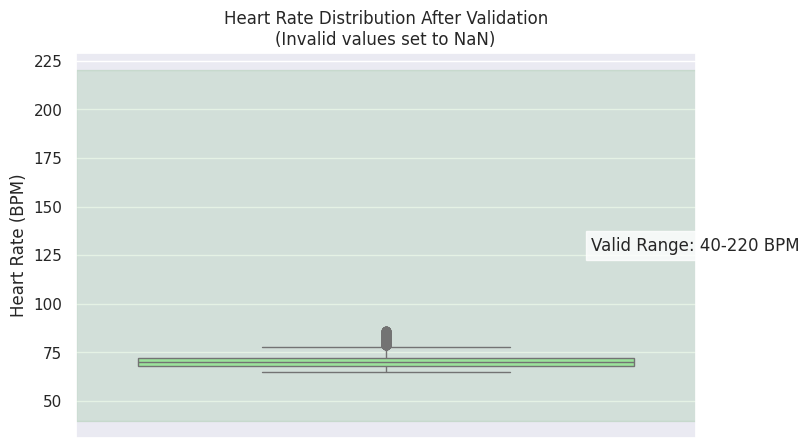

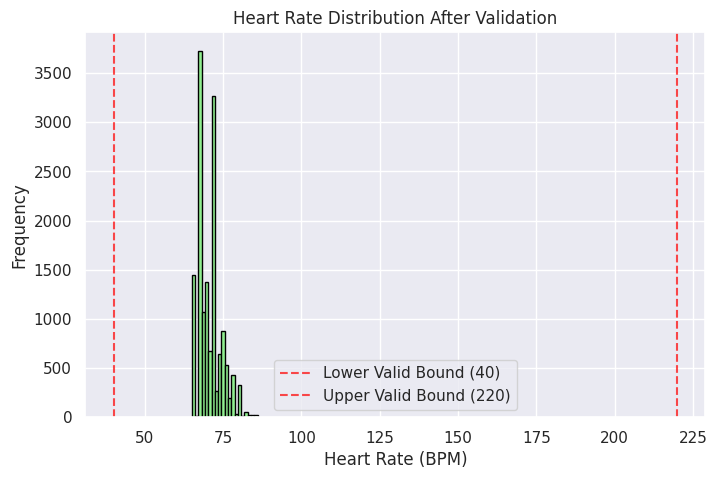

In [ ]:
# Heart Rate - After Validation Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(y=df['Heart Rate'], color='lightgreen')
plt.title('Heart Rate Distribution After Validation\n(Invalid values set to NaN)')
plt.ylabel('Heart Rate (BPM)')
# Add text annotation with the valid range
plt.axhspan(40, 220, alpha=0.1, color='green') # Highlight the valid range
plt.text(0.5, 130, 'Valid Range: 40-220 BPM', ha='center', va='center',
         bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# Heart Rate - After Validation Histogram
plt.figure(figsize=(8, 5))
plt.hist(df['Heart Rate'].dropna(), bins=20, color='lightgreen', edgecolor='black')
plt.title('Heart Rate Distribution After Validation')
plt.xlabel('Heart Rate (BPM)')
plt.ylabel('Frequency')
plt.axvline(40, color='red', linestyle='--', alpha=0.7, label='Lower Valid Bound (40)')
plt.axvline(220, color='red', linestyle='--', alpha=0.7, label='Upper Valid Bound (220)')
plt.legend()
plt.show()

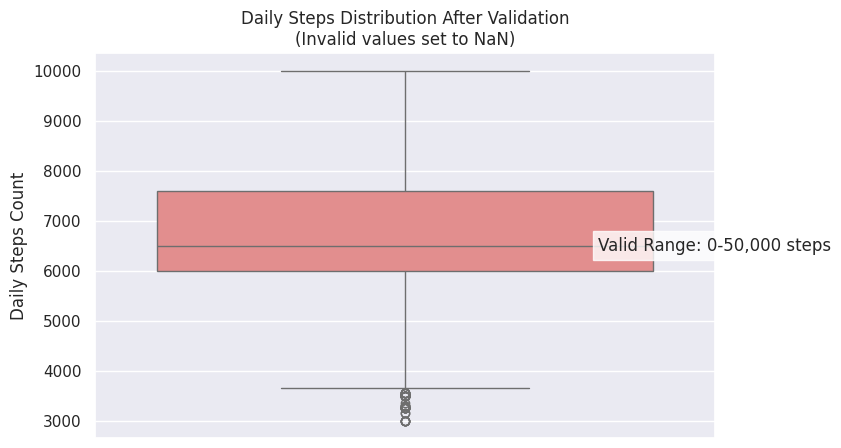

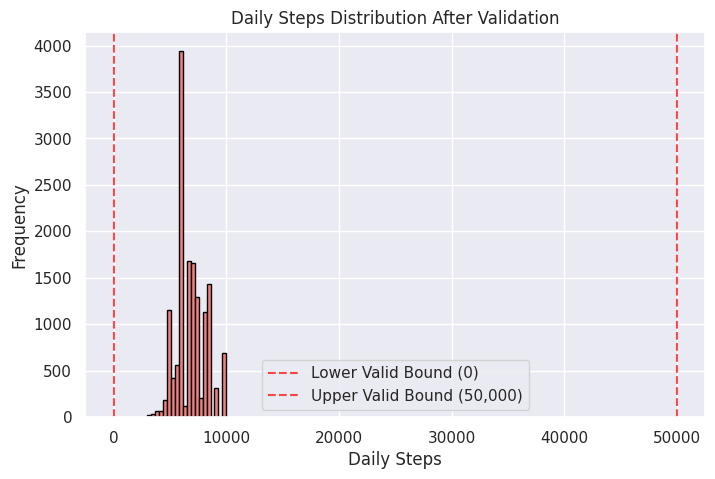

In [ ]:
# Daily Steps - After Validation Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(y=df['Daily Steps'], color='lightcoral')
plt.title('Daily Steps Distribution After Validation\n(Invalid values set to NaN)')
plt.ylabel('Daily Steps Count')
# Add text annotation with the valid range
plt.text(0.5, df['Daily Steps'].median(), f'Valid Range: 0-50,000 steps',
         ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# Daily Steps - After Validation Histogram
plt.figure(figsize=(8, 5))
plt.hist(df['Daily Steps'].dropna(), bins=20, color='lightcoral', edgecolor='black')
plt.title('Daily Steps Distribution After Validation')
plt.xlabel('Daily Steps')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', alpha=0.7, label='Lower Valid Bound (0)')
plt.axvline(50000, color='red', linestyle='--', alpha=0.7, label='Upper Valid Bound (50,000)')
plt.legend()
plt.show()

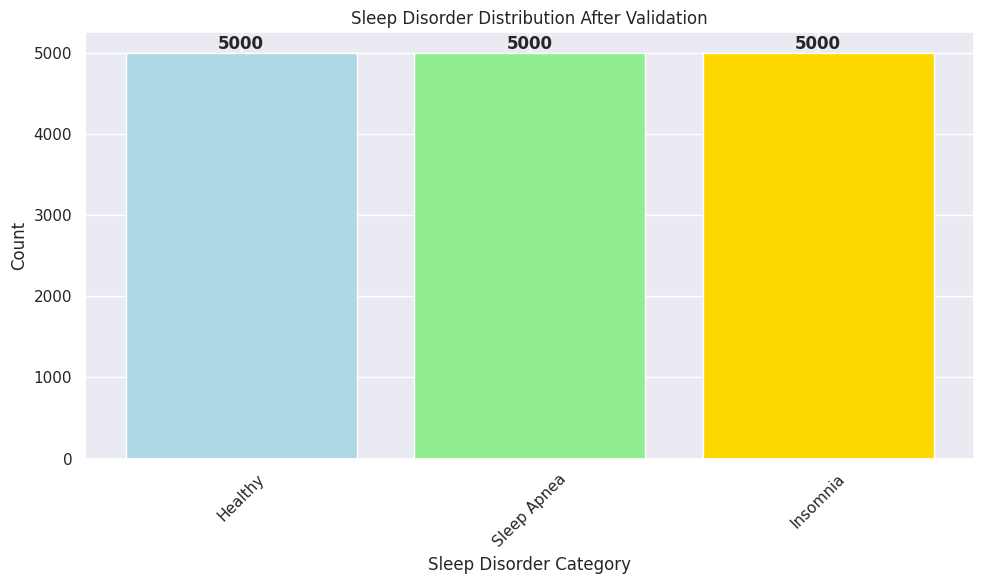

In [ ]:
# Sleep Disorder - After Validation Bar Chart
plt.figure(figsize=(10, 6))
disorder_counts = df['Sleep Disorder'].value_counts()
colors = ['lightblue', 'lightgreen', 'gold', 'lightcoral'] # Different colors for each category

bars = plt.bar(disorder_counts.index, disorder_counts.values, color=colors[:len(disorder_counts)])

plt.title('Sleep Disorder Distribution After Validation')
plt.xlabel('Sleep Disorder Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add value labels on top of each bar
for bar, value in zip(bars, disorder_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{value}',
             ha='center', va='bottom', fontweight='bold')

# Add a special annotation for the 'Unknown' category if it exists
if 'Unknown' in disorder_counts.index:
    unknown_index = list(disorder_counts.index).index('Unknown')
    plt.text(unknown_index, disorder_counts['Unknown']/2, 'Invalid Values\nMapped Here',
             ha='center', va='center', fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,35,Doctor,6.65,7,50,7,Normal Weight,120/80,71,7100,Healthy
1,2,Male,42,Teacher,6.90,8,52,4,Normal,135/90,66,7000,Healthy
2,3,Male,34,Software Engineer,6.95,7,66,6,Overweight,126/83,74,6100,Healthy
3,4,Male,32,Doctor,6.90,6,52,7,Normal,120/80,71,6500,Healthy
4,5,Male,37,Lawyer,6.85,7,60,6,Normal,125/80,71,6500,Healthy


3. Outliers HAdling

In [22]:
## Check dimensions
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns")
df.info() # Shows data types
df.describe().T # .T transposes the table for easier reading

df.describe(include='all').T

Dataset has 15000 rows and 13 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                15000 non-null  int64  
 1   Gender                   15000 non-null  object 
 2   Age                      15000 non-null  int64  
 3   Occupation               15000 non-null  object 
 4   Sleep Duration           15000 non-null  float64
 5   Quality of Sleep         15000 non-null  int64  
 6   Physical Activity Level  15000 non-null  int64  
 7   Stress Level             15000 non-null  int64  
 8   BMI Category             15000 non-null  object 
 9   Blood Pressure           15000 non-null  object 
 10  Heart Rate               15000 non-null  int64  
 11  Daily Steps              15000 non-null  int64  
 12  Sleep Disorder           15000 non-null  object 
dtypes: float64(1), int64(7), object(5)
mem

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Person ID,15000.0,NaN,NaN,NaN,7500.5,4330.271354,1.0,3750.75,7500.5,11250.25,15000.0
Gender,15000,2,Female,8569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,15000.0,NaN,NaN,NaN,44.130667,6.840091,27.0,40.0,44.0,48.0,59.0
Occupation,15000,11,Nurse,4316,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sleep Duration,15000.0,NaN,NaN,NaN,6.997327,0.615187,5.8,6.5,7.0,7.45,8.5
Quality of Sleep,15000.0,NaN,NaN,NaN,7.131267,1.053111,4.0,6.0,7.0,8.0,9.0
Physical Activity Level,15000.0,NaN,NaN,NaN,59.925,16.814374,30.0,45.0,60.0,75.0,90.0
Stress Level,15000.0,NaN,NaN,NaN,5.6548,1.393568,3.0,4.0,6.0,6.0,8.0
BMI Category,15000,4,Overweight,8755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Blood Pressure,15000,25,130/85,4194,NaN,NaN,NaN,NaN,NaN,NaN,NaN


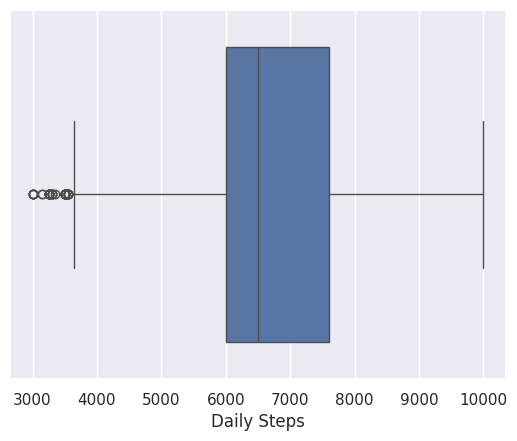

In [23]:
sns.boxplot(x=df['Daily Steps'])
plt.show()

To cisually confirm these outliers, first createsa boxplot.

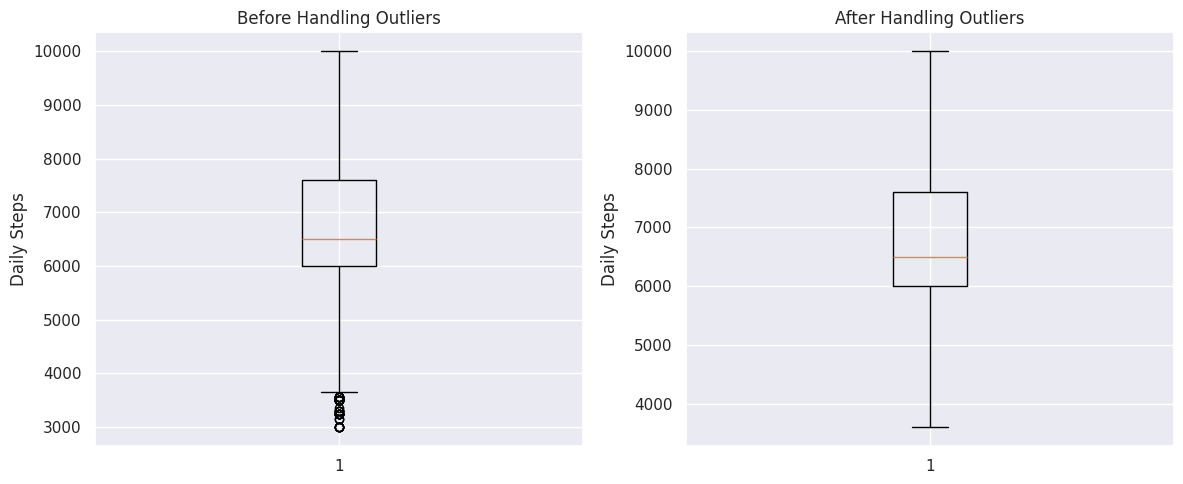

Lower bound: 3600.00
Upper bound: 10000.00


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create subplots to compare before and after
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before handling outliers
ax1.boxplot(df['Daily Steps'].dropna())
ax1.set_title('Before Handling Outliers')
ax1.set_ylabel('Daily Steps')

# Calculate IQR and bounds
Q1 = df['Daily Steps'].quantile(0.25)
Q3 = df['Daily Steps'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Clip the values
df['Daily Steps'] = np.clip(df['Daily Steps'], lower_bound, upper_bound)

# After handling outliers
ax2.boxplot(df['Daily Steps'].dropna())
ax2.set_title('After Handling Outliers')
ax2.set_ylabel('Daily Steps')

plt.tight_layout()
plt.show()

print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

This method doesn't remove the data points entirely. Instead, it brings any extreme values that fall below the lower bound up to the lower bound, and any values that exceed the upper bound down to the upper bound. This effectively limits the influence of the outliers without deleting them.

chose the capping method because, for a feature like 'Daily Steps', outliers are not necessarily errors but often represent real-world behavioral extremes

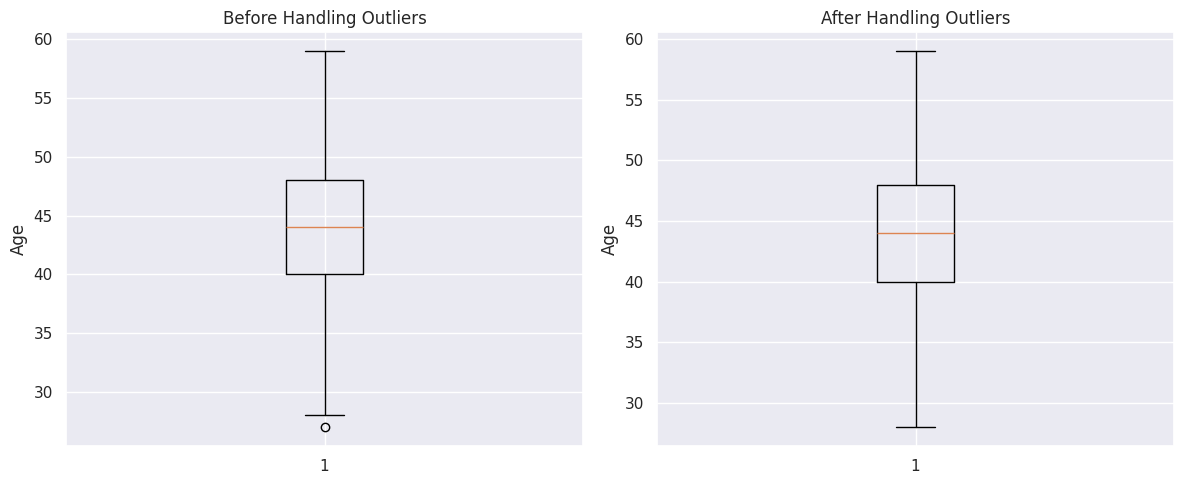

Lower bound: 28.00
Upper bound: 60.00


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create subplots to compare before and after
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before handling outliers
ax1.boxplot(df['Age'].dropna())
ax1.set_title('Before Handling Outliers')
ax1.set_ylabel('Age')

# Calculate IQR and bounds
Q1 = df['Age'].quantile(0.25)
Q3 = df['Age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Clip the values
df['Age'] = np.clip(df['Age'], lower_bound, upper_bound)

# After handling outliers
ax2.boxplot(df['Age'].dropna())
ax2.set_title('After Handling Outliers')
ax2.set_ylabel('Age')

plt.tight_layout()
plt.show()

print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

chose the capping method because, ouliers are in practical range

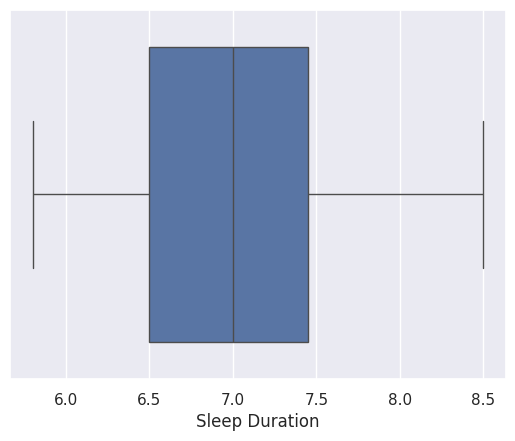

In [26]:
sns.boxplot(x=df['Sleep Duration'])
plt.show()

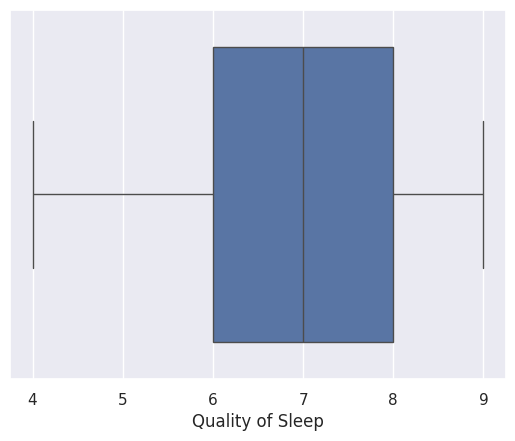

In [27]:
sns.boxplot(x=df['Quality of Sleep'])
plt.show()

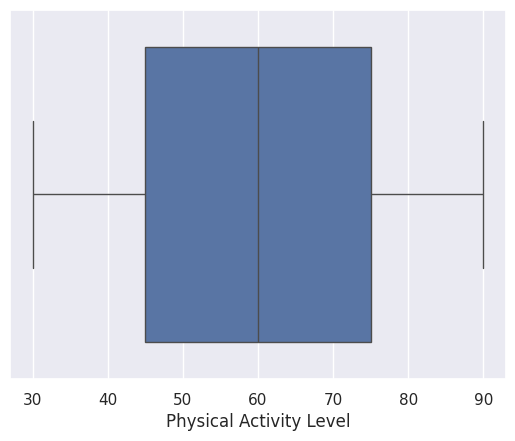

In [28]:
sns.boxplot(x=df['Physical Activity Level'])
plt.show()

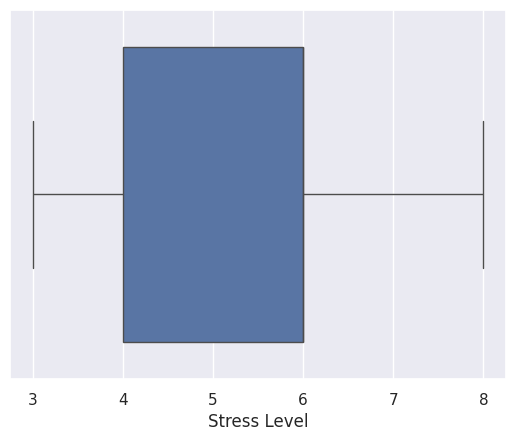

In [29]:
sns.boxplot(x=df['Stress Level'])
plt.show()

Before removal:
Dataset shape: (15000, 13)
Lower bound: 62.00
Upper bound: 78.00
Number of outliers in Heart Rate: 479

After removal:
Dataset shape: (14521, 13)
Number of rows removed: 479


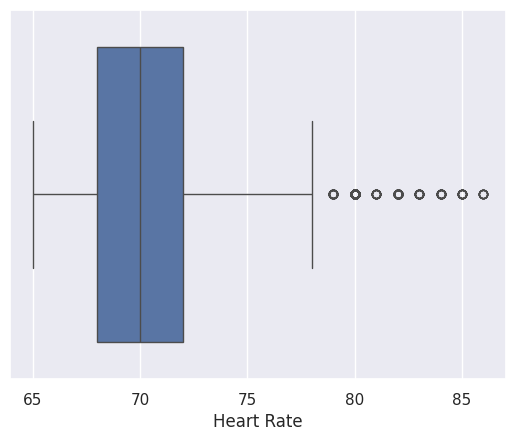

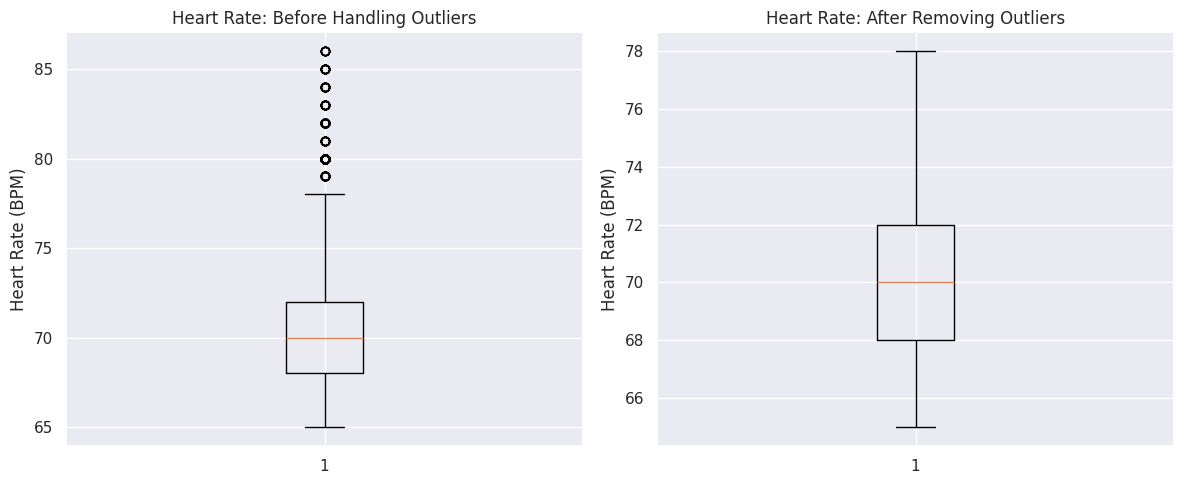


Sample of removed outlier rows:
      Heart Rate
4842          80
4873          86
4890          80
4905          80
4924          80


In [30]:
sns.boxplot(x=df['Heart Rate'])# Create a copy of the original dataframe for comparison
df_original = df.copy()

# Create subplots to compare before and after
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before handling outliers - Heart Rate
ax1.boxplot(df['Heart Rate'].dropna())
ax1.set_title('Heart Rate: Before Handling Outliers')
ax1.set_ylabel('Heart Rate (BPM)')

# Calculate IQR and bounds for Heart Rate
Q1 = df['Heart Rate'].quantile(0.25)
Q3 = df['Heart Rate'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Before removal:")
print(f"Dataset shape: {df.shape}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

# Identify outliers in Heart Rate
outlier_mask = (df['Heart Rate'] < lower_bound) | (df['Heart Rate'] > upper_bound)
num_outliers = outlier_mask.sum()
print(f"Number of outliers in Heart Rate: {num_outliers}")

# Remove rows with outliers in Heart Rate
df_clean = df[~outlier_mask]  # Keep rows that are NOT outliers

print("\nAfter removal:")
print(f"Dataset shape: {df_clean.shape}")
print(f"Number of rows removed: {len(df) - len(df_clean)}")

# After handling outliers - Heart Rate
ax2.boxplot(df_clean['Heart Rate'].dropna())
ax2.set_title('Heart Rate: After Removing Outliers')
ax2.set_ylabel('Heart Rate (BPM)')

plt.tight_layout()
plt.show()

# Show some of the removed outliers
if num_outliers > 0:
    print("\nSample of removed outlier rows:")
    print(df[outlier_mask][['Heart Rate']].head())
else:
    print("\nNo outliers found in Heart Rate feature.")
plt.show()

Extreme heart rate values could be due to sensor malfunctions or data recording errors, making them unreliable for our analysis.


In [31]:
# Count inconsistent gender entries
valid_genders = ['male', 'female']
invalid_count = (~df['Gender'].astype(str).str.strip().str.lower().isin(valid_genders)).sum()

print(f" Number of wrong/inconsistent gender entries: {invalid_count}")


 Number of wrong/inconsistent gender entries: 0


2. Standerdization

In [32]:
df['Gender'] = df['Gender'].str.strip().str.lower().map({
    'male': 'Male',
    'female': 'Female'
})

print(df['Gender'].unique())

['Male' 'Female']


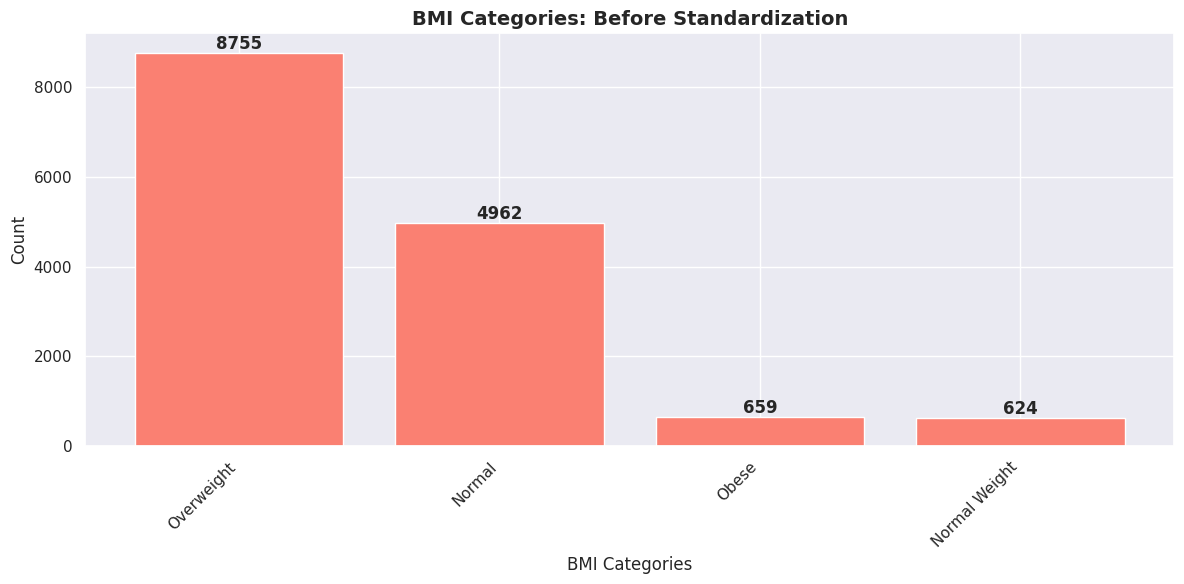

In [35]:
import matplotlib.pyplot as plt

# Plot BEFORE standardization
plt.figure(figsize=(12, 6))

# Get value counts before cleaning
bmi_before = df['BMI Category'].astype(str).str.strip().str.title()
value_counts_before = bmi_before.value_counts()

# Create bar plot
bars_before = plt.bar(value_counts_before.index, value_counts_before.values, color='salmon')
plt.title('BMI Categories: Before Standardization', fontsize=14, fontweight='bold')
plt.xlabel('BMI Categories')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for bar, value in zip(bars_before, value_counts_before.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{value}',
             ha='center', va='bottom', fontweight='bold')

# Highlight invalid entries by drawing a red box around them (optional)
# You would need to identify which categories are invalid based on your valid list

plt.tight_layout()
plt.show()



In [36]:
# List all unique BMI categories in the dataset
unique_bmi_categories = df['BMI Category'].unique()
print("Existing BMI categories in dataset:", unique_bmi_categories)


Existing BMI categories in dataset: ['Normal Weight' 'Normal' 'Overweight' 'Obese']


In [37]:

valid_bmi_categories = ['Underweight', 'Normal', 'Overweight', 'Obese']


bmi_lower = df['BMI Category'].astype(str).str.strip().str.title()


invalid_bmi_count = (~bmi_lower.isin(valid_bmi_categories)).sum()

print(f" Number of wrong inconsistent BMI entries: {invalid_bmi_count}")


 Number of wrong inconsistent BMI entries: 624


In [38]:
# Standardize BMI categories to only 3 valid categories
valid_bmi_map = {
    'normal': 'Normal',
    'normall': 'Normal',
    'Normal Weight': 'Normal',
    'overweight': 'Overweight',
    'overwaight': 'Overweight',
    'obese': 'Obese',
    'underweight': 'Underweight'
}


df['BMI Category'] = df['BMI Category'].astype(str).str.strip().str.lower().map(valid_bmi_map)

 #check the result
print(" Standardized BMI categories:")
print(df['BMI Category'].value_counts())



 Standardized BMI categories:
BMI Category
Overweight    8755
Normal        4962
Obese          659
Name: count, dtype: int64


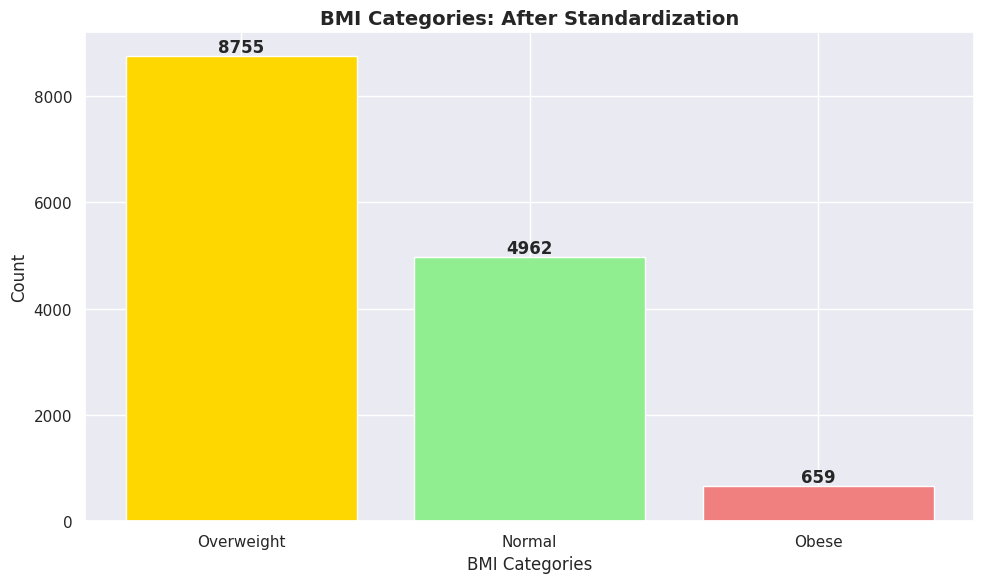

Standardized BMI categories distribution:
BMI Category
Overweight    8755
Normal        4962
Obese          659
Name: count, dtype: int64


In [39]:
# Plot AFTER standardization
plt.figure(figsize=(10, 6))

# Get value counts after cleaning
value_counts_after = df['BMI Category'].value_counts()

# Create bar plot with consistent colors for each category
colors = {'Underweight': 'lightblue', 'Normal': 'lightgreen', 'Overweight': 'gold', 'Obese': 'lightcoral'}
bar_colors = [colors.get(cat, 'gray') for cat in value_counts_after.index]

bars_after = plt.bar(value_counts_after.index, value_counts_after.values, color=bar_colors)
plt.title('BMI Categories: After Standardization', fontsize=14, fontweight='bold')
plt.xlabel('BMI Categories')
plt.ylabel('Count')

# Add value labels on top of bars
for bar, value in zip(bars_after, value_counts_after.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{value}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("Standardized BMI categories distribution:")
print(value_counts_after)

created a mapping dictionary to standardize all variations to Three consistent categories:  Normal, Overweight, and Obese.

In [40]:
# List all unique Sleep Disorder in the dataset
unique_bmi_categories = df['Sleep Disorder'].unique()
print("Existing BMI categories in dataset:", unique_bmi_categories)


Existing BMI categories in dataset: ['Healthy' 'Sleep Apnea' 'Insomnia']


In [41]:
# List all unique occupations in the dataset
unique_occupations = df['Occupation'].unique()
print("Unique occupations in the dataset:")
print(unique_occupations)


Unique occupations in the dataset:
['Doctor' 'Teacher' 'Software Engineer' 'Lawyer' 'Engineer' 'Accountant'
 'Nurse' 'Scientist' 'Manager' 'Salesperson' 'Sales Representative']


In [42]:
# Identify numeric and categorical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

print("Numeric Columns:", list(numeric_columns))
print("Categorical Columns:", list(categorical_columns))

Numeric Columns: ['Person ID', 'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']
Categorical Columns: ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder']


In [43]:

valid_occupations = [
    'Doctor', 'Teacher', 'Software Engineer', 'Lawyer', 'Engineer',
    'Accountant', 'Nurse', 'Scientist', 'Manager', 'Salesperson'
]


occupation_map = {occ.lower(): occ for occ in valid_occupations}


df['Occupation'] = df['Occupation'].astype(str).str.strip().str.lower().map(occupation_map)


print(df['Occupation'].head(20))
df.head(20)



0                Doctor
1               Teacher
2     Software Engineer
3                Doctor
4                Lawyer
5                Doctor
6              Engineer
7              Engineer
8                Lawyer
9              Engineer
10             Engineer
11             Engineer
12             Engineer
13           Accountant
14             Engineer
15               Doctor
16           Accountant
17               Doctor
18               Lawyer
19             Engineer
Name: Occupation, dtype: object


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,35,Doctor,6.65,7,50,7,NaN,120/80,71,7100,Healthy
1,2,Male,42,Teacher,6.90,8,52,4,Normal,135/90,66,7000,Healthy
2,3,Male,34,Software Engineer,6.95,7,66,6,Overweight,126/83,74,6100,Healthy
3,4,Male,32,Doctor,6.90,6,52,7,Normal,120/80,71,6500,Healthy
4,5,Male,37,Lawyer,6.85,7,60,6,Normal,125/80,71,6500,Healthy
5,6,Male,33,Doctor,6.90,7,50,6,NaN,120/80,69,7500,Healthy
6,7,Male,44,Engineer,7.85,8,45,4,Normal,125/80,65,5000,Healthy
7,8,Male,40,Engineer,8.05,8,52,4,Normal,120/80,68,6500,Healthy
8,9,Male,36,Lawyer,6.85,7,60,6,Normal,130/85,71,6500,Healthy
9,10,Male,40,Engineer,7.15,7,58,6,NaN,130/85,70,6500,Healthy


In [44]:
# Identify numeric and categorical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

print("Numeric Columns:", list(numeric_columns))
print("Categorical Columns:", list(categorical_columns))

Numeric Columns: ['Person ID', 'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']
Categorical Columns: ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder']


Correlations

EDA

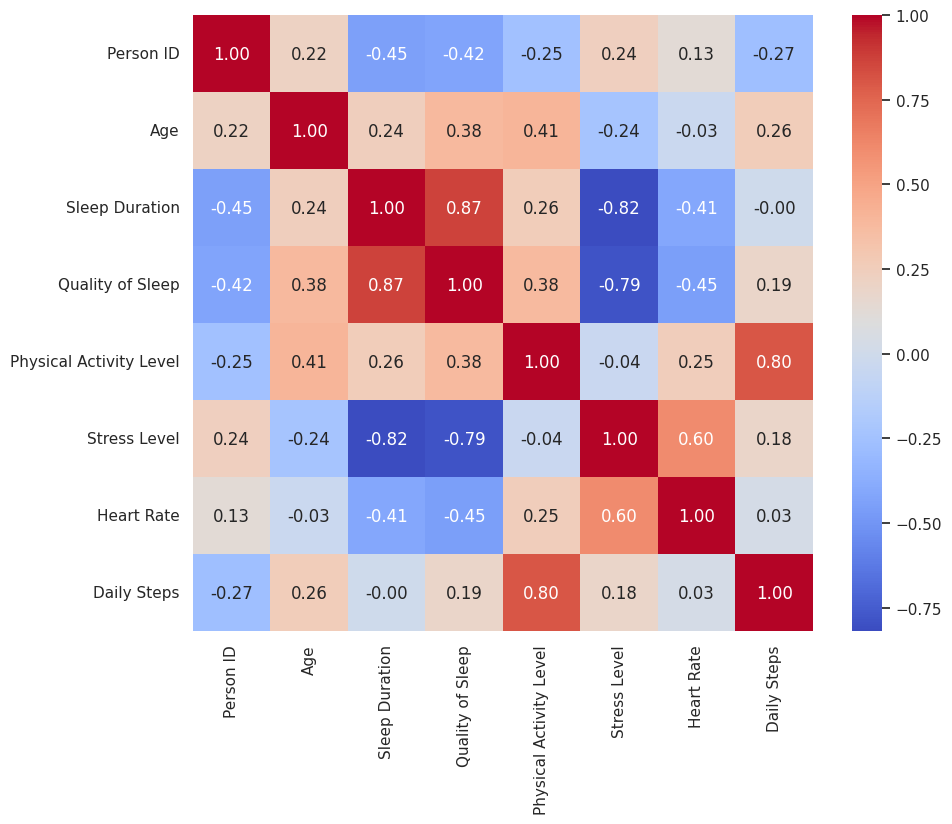

In [45]:
plt.figure(figsize=(10, 8))
# Calculate correlation only for numerical columns
numerical_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

Feature Engineering Part 01

In [47]:
# Identify numeric and categorical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

print("Numeric Columns:", list(numeric_columns))
print("Categorical Columns:", list(categorical_columns))

Numeric Columns: ['Person ID', 'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']
Categorical Columns: ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder']


In [48]:
# Split Blood Pressure into Systolic and Diastolic
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
# Remove rows with systolic > 180 or diastolic > 120
df = df[(df['Systolic'] <= 180) & (df['Diastolic'] <= 120)]
print(df[['Systolic', 'Diastolic']].head())

   Systolic  Diastolic
0       120         80
1       135         90
2       126         83
3       120         80
4       125         80


In [49]:
# Drop the 'Blood Pressure' column as it's now redundant
df.drop(columns=['Blood Pressure'], inplace=True)
df.drop(columns=['Person ID'], inplace=True)
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
0,Male,35,Doctor,6.65,7,50,7,NaN,71,7100,Healthy,120,80
1,Male,42,Teacher,6.90,8,52,4,Normal,66,7000,Healthy,135,90
2,Male,34,Software Engineer,6.95,7,66,6,Overweight,74,6100,Healthy,126,83
3,Male,32,Doctor,6.90,6,52,7,Normal,71,6500,Healthy,120,80
4,Male,37,Lawyer,6.85,7,60,6,Normal,71,6500,Healthy,125,80


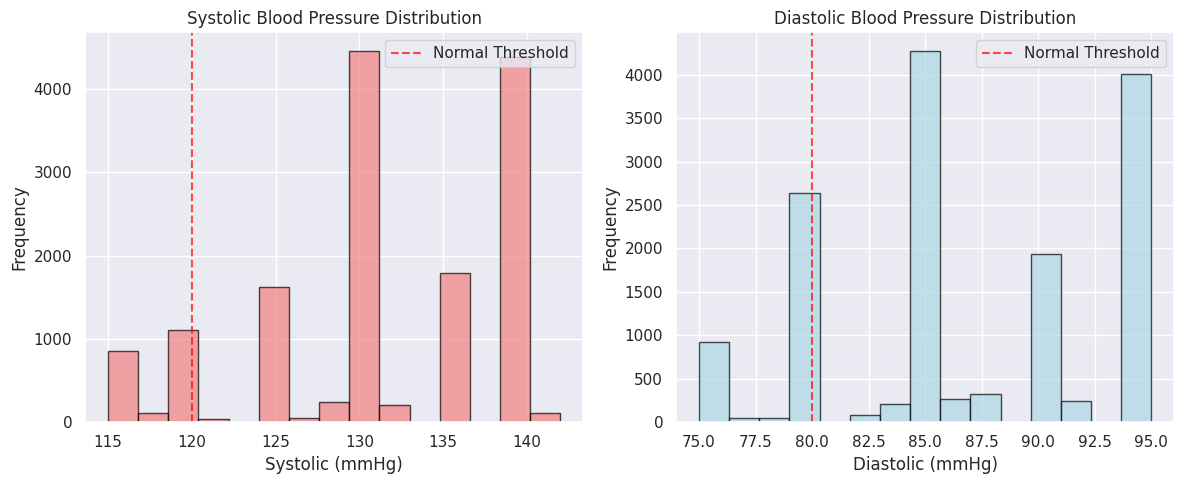

In [50]:
# After splitting - show distribution of new features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Systolic distribution
ax1.hist(df['Systolic'], bins=15, color='lightcoral', edgecolor='black', alpha=0.7)
ax1.set_title('Systolic Blood Pressure Distribution')
ax1.set_xlabel('Systolic (mmHg)')
ax1.set_ylabel('Frequency')
ax1.axvline(120, color='red', linestyle='--', alpha=0.7, label='Normal Threshold')
ax1.legend()

# Diastolic distribution
ax2.hist(df['Diastolic'], bins=15, color='lightblue', edgecolor='black', alpha=0.7)
ax2.set_title('Diastolic Blood Pressure Distribution')
ax2.set_xlabel('Diastolic (mmHg)')
ax2.set_ylabel('Frequency')
ax2.axvline(80, color='red', linestyle='--', alpha=0.7, label='Normal Threshold')
ax2.legend()

plt.tight_layout()
plt.show()

 split the composite field into two separate numerical features: Systolic and Diastolic. This is crucial because systolic and diastolic pressures have different clinical implications and should be analyzed separately by our machine learning models.

 removed the original composite 'Blood Pressure' column as it became redundant, and also dropped the 'Person ID' column as it's merely an identifier with no predictive value.

In [51]:
# Identify numeric and categorical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

print("Numeric Columns:", list(numeric_columns))
print("Categorical Columns:", list(categorical_columns))

Numeric Columns: ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']
Categorical Columns: ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']


Encoding

In [52]:
# Import the necessary library
from sklearn.preprocessing import OneHotEncoder

# Separate ordinal and nominal variables
ordinal_vars = ['Gender', 'BMI Category']  # Good for Label Encoding
nominal_vars = ['Occupation', 'Sleep Disorder']  # Requires One-Hot Encoding

# Apply Label Encoding to ordinal variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['BMI Category'] = le.fit_transform(df['BMI Category'])

# Apply One-Hot Encoding to nominal variables - CREATE SEPARATE ENCODER FOR EACH
ohe_occupation = OneHotEncoder(sparse_output=False, drop='first')  # encoder for Occupation
ohe_sleep = OneHotEncoder(sparse_output=False, drop='first')       # encoder for Sleep Disorder

# Fit and transform each nominal variable separately
occupation_encoded = ohe_occupation.fit_transform(df[['Occupation']])
sleep_disorder_encoded = ohe_sleep.fit_transform(df[['Sleep Disorder']])

# Get feature names for the encoded columns
occupation_feature_names = ohe_occupation.get_feature_names_out(['Occupation'])
sleep_disorder_feature_names = ohe_sleep.get_feature_names_out(['Sleep Disorder'])

# Create DataFrames from the encoded arrays
occupation_df = pd.DataFrame(occupation_encoded, columns=occupation_feature_names)
sleep_disorder_df = pd.DataFrame(sleep_disorder_encoded, columns=sleep_disorder_feature_names)

# Concatenate the encoded features with the original DataFrame
df = pd.concat([df, occupation_df, sleep_disorder_df], axis=1)

# Drop the original nominal columns
df.drop(columns=['Occupation', 'Sleep Disorder'], inplace=True)

# Display the results
print("DataFrame shape after encoding:", df.shape)
print("\nNew columns added:")
print([col for col in df.columns if 'Occupation_' in col or 'Sleep_Disorder_' in col])

DataFrame shape after encoding: (15000, 23)

New columns added:
['Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Lawyer', 'Occupation_Manager', 'Occupation_Nurse', 'Occupation_Salesperson', 'Occupation_Scientist', 'Occupation_Software Engineer', 'Occupation_Teacher', 'Occupation_nan']


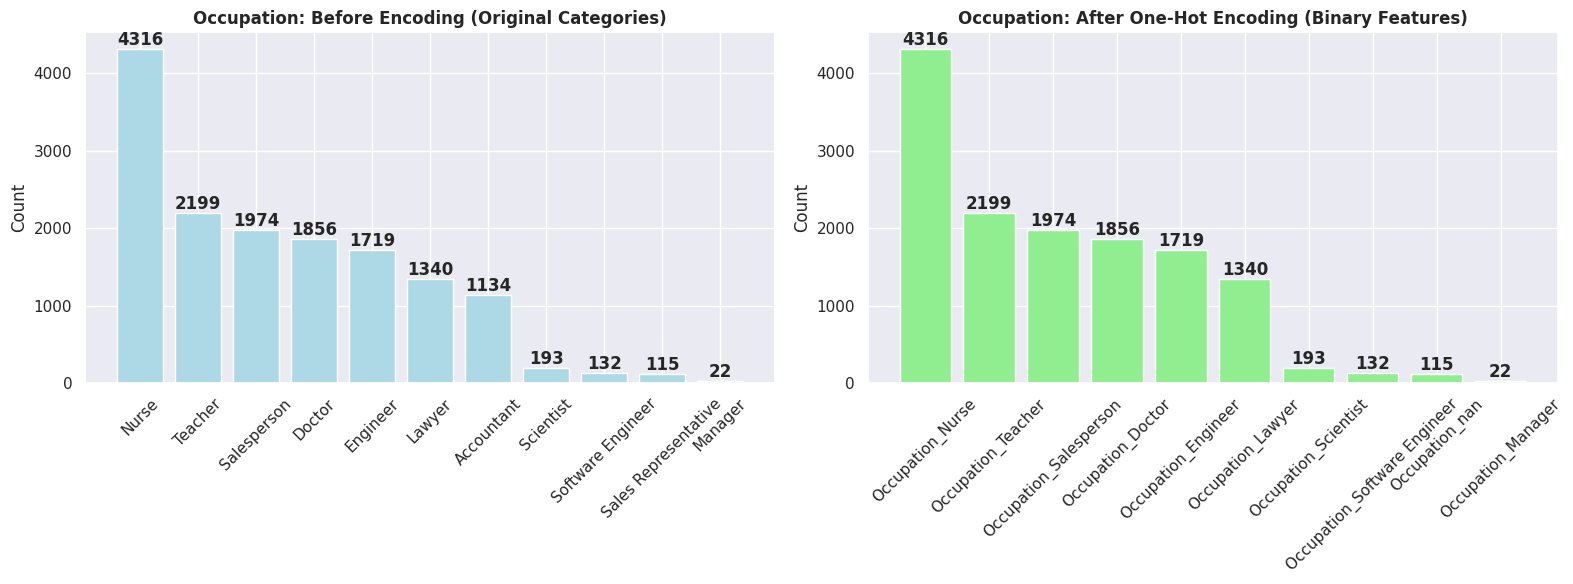

In [53]:
# Create comparison visualization for Occupation encoding
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Before Encoding - Original Categories
value_counts_before = df_original['Occupation'].value_counts()
bars_before = ax1.bar(value_counts_before.index, value_counts_before.values, color='lightblue')
ax1.set_title('Occupation: Before Encoding (Original Categories)', fontweight='bold')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
# Add values on bars
for bar, value in zip(bars_before, value_counts_before.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{value}',
             ha='center', va='bottom', fontweight='bold')

# After Encoding - One-Hot Encoding Representation
occupation_cols = [col for col in df.columns if 'Occupation_' in col]
value_counts_after = df[occupation_cols].sum().sort_values(ascending=False)
bars_after = ax2.bar(value_counts_after.index, value_counts_after.values, color='lightgreen')
ax2.set_title('Occupation: After One-Hot Encoding (Binary Features)', fontweight='bold')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)
# Add values on bars
for bar, value in zip(bars_after, value_counts_after.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{int(value)}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [54]:
# Identify numeric and categorical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

print("Numeric Columns:", list(numeric_columns))
print("Categorical Columns:", list(categorical_columns))

Numeric Columns: ['Gender', 'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic', 'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Lawyer', 'Occupation_Manager', 'Occupation_Nurse', 'Occupation_Salesperson', 'Occupation_Scientist', 'Occupation_Software Engineer', 'Occupation_Teacher', 'Occupation_nan', 'Sleep Disorder_Insomnia', 'Sleep Disorder_Sleep Apnea']
Categorical Columns: []


1. Label Encoding for Ordinal Variables: Gender and BMI Category
       Gender:  This is a binary nominal variable with only two possible values: Male and Female
        BMI: This is a classic ordinal variable. The categories have a clear and meaningful order:
  2. One-Hot Encoding for Nominal Variables: Occupation and Sleep Disorder
        This feature has 10 distinct categories (e.g., Engineer, Doctor, Teacher, Lawyer). These professions have no logical order or hierarchy; one is not 'greater than' or 'less than' another. Using Label Encoding here would be a critical mistake
        

Feature Engineering Part 2

In [55]:
#Feature Engineering


# Calculate Mean Arterial Pressure (MAP)
df['MAP'] = (df['Systolic'] + 2 * df['Diastolic']) / 3

# Create Sleep Efficiency
df['Sleep Efficiency'] = df['Sleep Duration'] * df['Quality of Sleep']

# Create Activity-to-Steps Ratio (handle division by zero)
df['Activity_Steps_Ratio'] = df['Physical Activity Level'] / df['Daily Steps'].replace(0, np.nan)

# Create Stress-to-Sleep Ratio (handle division by zero)
df['Stress_Sleep_Ratio'] = df['Stress Level'] / df['Quality of Sleep'].replace(0, np.nan)



print("Dataset with New Features:\n", df.head())

Dataset with New Features:
    Gender  Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
0       1   35            6.65                 7                       50   
1       1   42            6.90                 8                       52   
2       1   34            6.95                 7                       66   
3       1   32            6.90                 6                       52   
4       1   37            6.85                 7                       60   

   Stress Level  BMI Category  Heart Rate  Daily Steps  Systolic  ...  \
0             7             3          71         7100       120  ...   
1             4             0          66         7000       135  ...   
2             6             2          74         6100       126  ...   
3             7             0          71         6500       120  ...   
4             6             0          71         6500       125  ...   

   Occupation_Scientist  Occupation_Software Engineer  Occupation_Teac

Dataset with 27 one-hot encoded features results in a 27x27 correlation matrix with 729 individual correlation coefficients. This is far beyond the human brain's capacity to process meaningfully. The resulting heatmap is a "muddy" grid of squares, making it impossible to discern any meaningful patterns.

PCA Solution: By definition, PCs are orthogonal (uncorrelated). The resulting correlation heatmap of the PCs will have a diagonal of 1 (each PC is perfectly correlated with itself) and zeros everywhere else. This "clean" heatmap immediately confirms that PCA has successfully distilled the data into its core, independent drivers. The insight then comes from the next step: analyzing the loadings.

PCA


In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame with the 27 one-hot encoded feature columns
# Separate the features (X) - exclude the target if it's in this DataFrame
X = df # or df.drop('target_column', axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

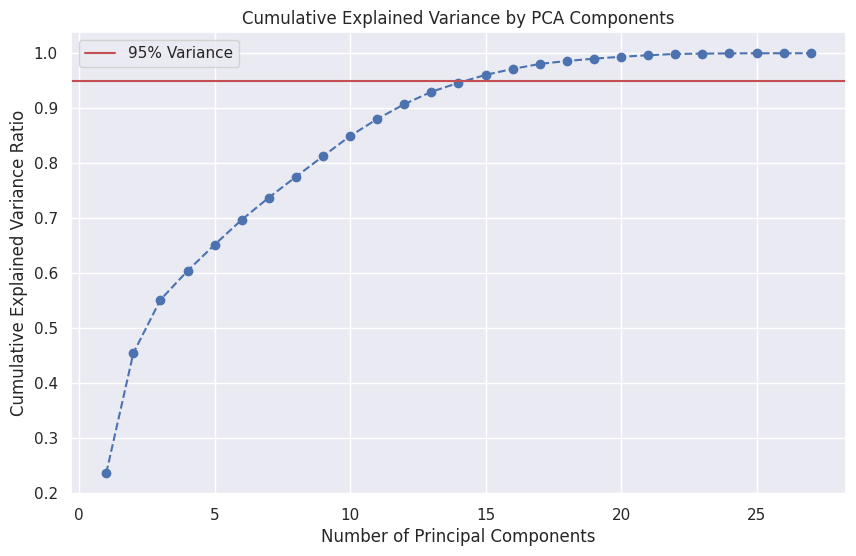

In [57]:
# Fit PCA to the data
pca = PCA()
pca.fit(X_scaled)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variance') # Common threshold
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# Re-fit PCA with the chosen number of components
n_components = 5
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for the new components
pca_columns = [f'PC_{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)

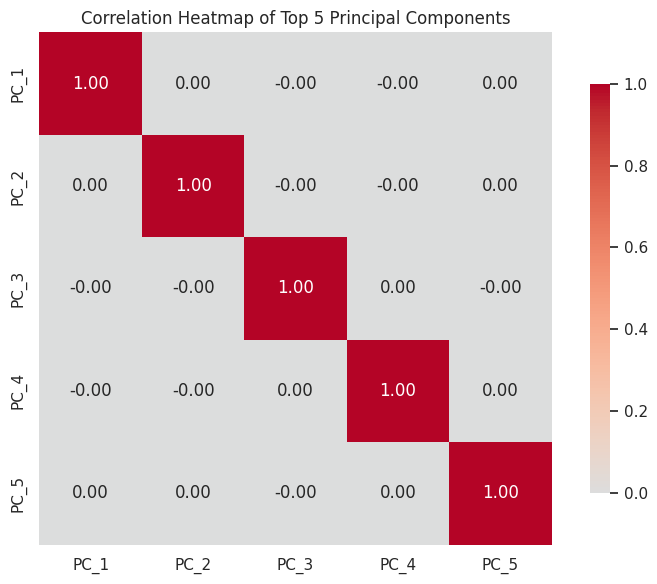

In [59]:
# Calculate the correlation matrix of the principal components
corr_matrix_pca = df_pca.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_pca, annot=True, cmap='coolwarm', center=0, fmt=".2f",
            square=True, cbar_kws={"shrink": .8})
plt.title(f'Correlation Heatmap of Top {n_components} Principal Components')
plt.tight_layout()
plt.show()

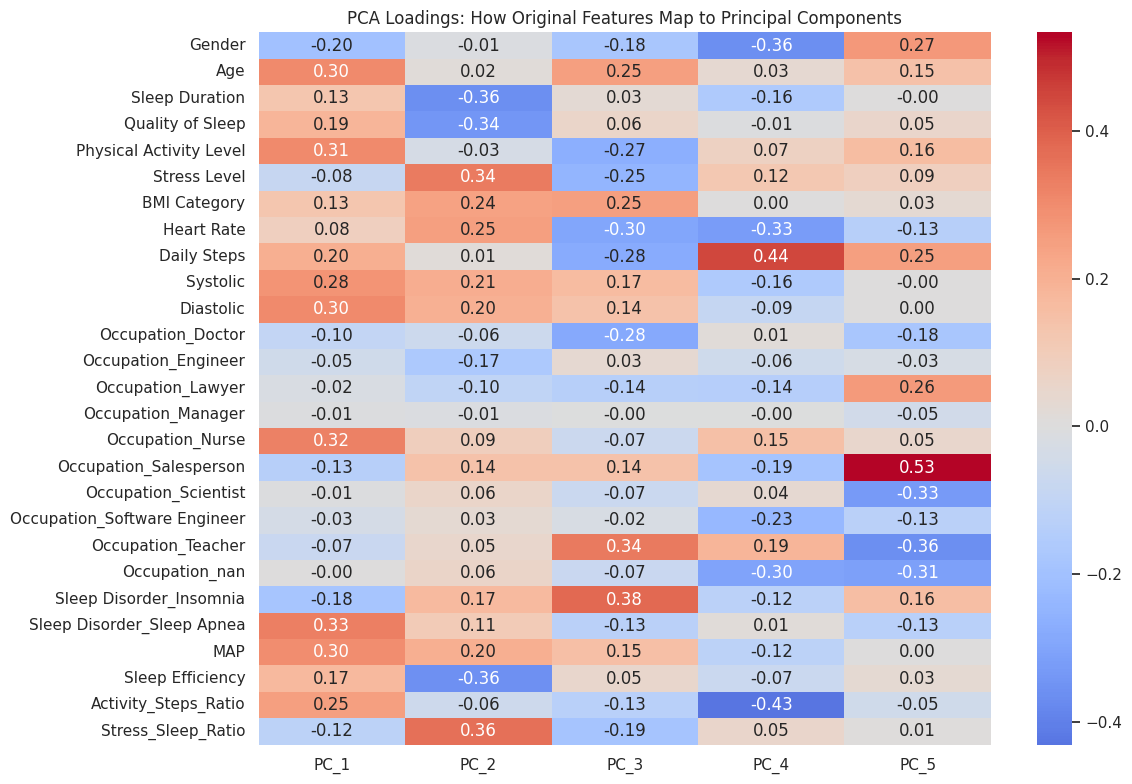

In [60]:
# Get the loadings (how each original feature contributes to each PC)
loadings = pca.components_.T
df_loadings = pd.DataFrame(loadings, columns=pca_columns, index=df.columns)

# Now create a heatmap of the loadings
plt.figure(figsize=(12, 8))
sns.heatmap(df_loadings, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('PCA Loadings: How Original Features Map to Principal Components')
plt.tight_layout()
plt.show()

In [62]:
# Save the cleaned dataset to Google Drive
output_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Cleaned_Sleep_Data.csv'
df.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to: {output_path}")

Cleaned dataset saved to: /content/drive/MyDrive/Colab Notebooks/Dataset/Cleaned_Sleep_Data.csv
